In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
import os
import math
import codecs
from collections import Counter
from nltk import word_tokenize,sent_tokenize
from gensim.models import Word2Vec
import spacy
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from tqdm import tqdm
import ast
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score,mean_squared_error
from feature_extraction import TextFeatureCreator

def roundup(x):
    return int(math.ceil(x / 10.0)) * 10

In [7]:
#import zipfile
#zip_ref = zipfile.ZipFile("clean_newsela_article_files.zip", 'r')
#zip_ref.extractall("clean_newsela")
#zip_ref.close()

In [8]:
#lemmatizer
nlp = spacy.load('en_core_web_sm')

# NN to Predict Feature Scores

## Data Preparation

### Helper Functions

In [6]:
clean_newsela_path = "/data/ts_cost_function/clean_newsela/"

In [9]:
def yield_file_text(df):
    #generator that gives a text each time next(<generator>) is called
    for ind,row in df.iterrows():
        if row["path"] != 'data/LSATtexts.txt':
            yield get_file_text(row)

In [10]:
def get_file_text(row):
    #load the text from the file 
    #(used by yield_file_text)
    path = row["path"]#.split("/")[-1]
    #path= clean_newsela_path+path

    with codecs.open(path, "r",encoding='utf-8', errors='ignore') as f:
        text = f.read()
        #if tokenize:
        #    text = [[word.text.lower() for word in nlp(sent)] for sent in text.split(".")]
        return text

### Exchange lemmatized text by word2vec vectors

In [18]:
def text_to_vector(word2vec_model,text):
    vectorized_text = [
            [word2vec_model.wv[word] 
             for word in sent if word in lem_word2vec_model.wv.vocab] 
         for sent in text]
    
    #print(vectorized_text)
    vectorized_text = [sent for sent in vectorized_text if sent]
    return vectorized_text

In [19]:
df = pd.read_csv("/data/ts_cost_function/dataset_features_and_text.csv",sep="|")
df["text"] = df.apply(lambda x: ast.literal_eval(x["text"]),axis=1)
lem_word2vec_model = Word2Vec.load("/data/ts_cost_function/word2vec_lem.model")
vectorized_texts = df.apply(lambda x: text_to_vector(lem_word2vec_model,x["text"]),axis=1)
df["embed"] = vectorized_texts
df.head(1)

,path,feature_sums,regression_score,Mean word length,Mean sentence length,Basic english ratio,Syllables per sentence,Type token ratio,#nouns,#verbs,...,Coordination,Apposition,Passive verbs,Parataxis,Auxiliary Verbs,Negation,Prepositional Phrases,Modifiers,text,embed
0,/data/ts_cost_function/clean_newsela/kea-extin...,7.687178,0.326461,0.90909,0.306252,1.298557,0.263046,0.845914,0.365935,0.465726,...,0.202795,0.0,0.256415,0.0,0.366106,0.201348,0.203278,0.256116,"[[one, of, the, big, threat, to, the, kea, be,...","[[[2.2008598, 2.7345686, 1.5816159, -0.3842493..."


## TF Estimator Input_Fn

### Add padding at text and sentence level

In [31]:
def embed_padding(embed,max_sent,max_word,embed_size):
    result = np.zeros((max_sent,max_word,embed_size))
    for sent_ind,sent in enumerate(embed[:max_sent]):
        for word_ind,word in enumerate(sent[:max_word]):
            result[sent_ind,word_ind] = word
    return result

In [32]:
df["embed_pad"] = df.apply(
        lambda x: embed_padding(
            x["embed"],
            100,
            100,
            50),
        axis=1)

In [ ]:
#np.save('/data/ts_cost_function/embed_pad.npy', df["embed_pad"])
#Result: Memory Error

In [149]:
#arrays = np.stack(df["embed_pad"].values)
#Result: Memory Error

### Text Generators

In [42]:
feature_columns = df.columns[3:-3]
def word_embed_generator(df):
    #Yields each text and label of the training set
    for ind,row in df.iterrows():
        yield (row["embed_pad"],row[feature_columns])

In [61]:
def prediction_generator(df):
    #Yields only the text for prediction 
    for ind,row in df.iterrows():
        yield (row["embed_pad"],[0]*20)

### Define Input Functon

In [33]:
def train_word_emb_fn(df,batch_size,model):
    #Loads the training data for the tf estimator
    max_sent = model.params["text_size"]
    max_word = model.params["sent_size"]
    embed_size = model.params["word_size"]
    #dataset = tf.data.Dataset.from_tensor_slices((dict(df["embed_pad"]), df["regression_score"]))

    dataset = tf.data.Dataset.from_generator(lambda: 
                                             word_embed_generator(df), 
                                             (tf.float64, tf.float64), 
                                             (tf.TensorShape([max_sent,max_word,embed_size]),
                                             tf.TensorShape([20])))

    # Shuffle, repeat, and batch the examples.
    dataset = dataset.shuffle(1000).repeat().batch(batch_size)
    #shuffle(1000)
    
    # Return the dataset.
    return dataset

In [34]:
def eval_word_emb_fn(df,batch_size,model):
    #Loads the evaluation data for the tf estimator
    max_sent = model.params["text_size"]
    max_word = model.params["sent_size"]
    embed_size = model.params["word_size"]

    dataset = tf.data.Dataset.from_generator(lambda: 
                                             prediction_generator(df), 
                                             (tf.float64, tf.float64), 
                                             (tf.TensorShape([max_sent,max_word,embed_size]),
                                             tf.TensorShape([20])))

    dataset = dataset.batch(batch_size)

    # Return the read end of the pipeline.
    return dataset.make_one_shot_iterator().get_next()

## Define Training and Test Set

### Load Splitting

In [37]:
index_df = pd.read_csv("/data/ts_cost_function/train_test_indices.csv",sep=";")
train_df = df.iloc[index_df.loc[index_df["dataset"] == "train"]["index"].values]
test_df = df.iloc[index_df.loc[index_df["dataset"] == "test"]["index"].values]
train_df.head(1)

,path,feature_sums,regression_score,Mean word length,Mean sentence length,Basic english ratio,Syllables per sentence,Type token ratio,#nouns,#verbs,...,Apposition,Passive verbs,Parataxis,Auxiliary Verbs,Negation,Prepositional Phrases,Modifiers,text,embed,embed_pad
13620,/data/ts_cost_function/clean_newsela/planet-ni...,17.80152,0.67148,0.919342,0.784718,1.041918,0.735701,0.819199,0.842614,0.80318,...,0.788785,0.610511,2.874718,0.591498,1.198502,0.643021,0.68447,"[[an, answer, for, planet, ', strange, alignme...","[[[6.1390705, 2.7747629, -2.6474686, -0.170415...","[[[6.139070510864258, 2.7747628688812256, -2.6..."


## NN Architecture

### Embedding + Sentence RNN + Text RNN

In [54]:
model_path = "/data/ts_cost_function/model_emb_rnn_rnn_features"

hyperparameter = {
    "text_size" : 100,
    "sent_size" : 100,
    "word_size" : 50,
    "learning_rate": 0.0001,#0.0001
    "sent_hidden_state_size": 64,
    "text_hidden_state_size": 64
}

![architecture](../paper/jupyter_results/architecture_rnn_rnn.png)

#### Model Function

In [55]:
def model_emb_rnn_rnn_feature_fn(features, labels, mode, params):
    #Model Function of the architecture
    
    batch_size = global_batch_size
    text_size = params["text_size"]
    sent_size = params["sent_size"]
    word_size = params["word_size"]
    learn_rate = params["learning_rate"]
    sent_hidden_state_size = params["sent_hidden_state_size"]
    text_hidden_state_size = params["text_hidden_state_size"]
    #n_steps_summary = params["every_n_steps_summarize"]
    #model_path = params["model_path"]
    
    

    
    #Mask the length of each sentence 
    word_mask = tf.reduce_max(
        tf.count_nonzero(
            tf.reshape(
                features,
                [batch_size*text_size,sent_size,word_size]),
            1),
        1)
    #Mask the length of each text
    sent_mask = tf.count_nonzero(
        tf.reduce_max(
            tf.count_nonzero(
                features,
                2),
            2),
        1)
    
    #Concat all sentences of all texts of a batch together to use word_mask
    concat_sents = tf.reshape(features,[batch_size*text_size,sent_size,word_size])
    
    
    #LSTM for each word in a sentence
    with tf.variable_scope('word_cell'):
        word_cell = tf.contrib.rnn.BasicLSTMCell(num_units=sent_hidden_state_size, state_is_tuple=True)
        word_outputs, word_last_states = tf.nn.dynamic_rnn(
            cell=word_cell,
            dtype=tf.float64,
            sequence_length=word_mask,
            #initial_state=init_state,
            inputs=concat_sents)
        
        reshaped_word_last_states = tf.reshape(word_last_states.c,[batch_size,text_size,sent_hidden_state_size])
    
    #LSTM for each sentence in a text
    with tf.variable_scope('sent_cell'):
        sent_cell = tf.contrib.rnn.BasicLSTMCell(num_units=text_hidden_state_size, state_is_tuple=False)
        sent_outputs, sent_last_states = tf.nn.dynamic_rnn(
            cell=sent_cell,
            dtype=tf.float64,
            sequence_length=sent_mask,
            inputs=reshaped_word_last_states)
        
    #summary
    for name,cell in [("word",word_cell),("sent",sent_cell)]:
        one_kernel, one_bias = cell.variables
        # I think TensorBoard handles summaries with the same name fine.
        tf.summary.histogram(name+"_kernel", one_kernel)
        tf.summary.histogram(name+"_bias", one_bias)
    
    #shrink last hidden state of each text
    dense_layer = tf.layers.dense(inputs=sent_last_states, units=64, activation=None)
    
    pred_value = tf.layers.dense(inputs=dense_layer, units=20, activation=None)
    
    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        "logits": pred_value,
        "word_outputs":word_outputs,
        "sent_outputs":sent_outputs,
        "word_mask":word_mask,
        "sent_mask":sent_mask
        
    }
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=predictions)
    
    #MSE for loss
    reshaped_labels = tf.reshape(labels,[batch_size,20])
    print(reshaped_labels)
    cost = tf.losses.mean_squared_error(reshaped_labels,pred_value)
    mse = tf.metrics.mean_squared_error(reshaped_labels,pred_value)
    
    tf.summary.scalar('mse', mse[1])
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        #Adam Optimizer
        optimizer = tf.train.AdamOptimizer(
            learning_rate=learn_rate)
        train_op = optimizer.minimize(
            loss=cost,
            global_step=tf.train.get_global_step())
        
        return tf.estimator.EstimatorSpec(
            mode=mode, 
            loss=cost,
            train_op=train_op)
    
    print(cost)
    eval_metric_ops = {
      "MSE": mse}
    return tf.estimator.EstimatorSpec(
      mode=mode, loss=cost, eval_metric_ops=eval_metric_ops)
    

#### Create Estimator

In [56]:
#tf.reset_default_graph()

#Change the checkpoint config
checkpointing_config = tf.estimator.RunConfig(
    #save_checkpoints_secs = 60*10,  # Save checkpoints every 10 minutes.
    keep_checkpoint_max = 5,       # Retain the 10 most recent checkpoints.
    save_summary_steps=10
)

#Define Estimator
model_emb_rnn_rnn = tf.estimator.Estimator(
    model_fn=model_emb_rnn_rnn_feature_fn, 
    model_dir=model_path,
    params=hyperparameter,
    config=checkpointing_config)

tf.logging.set_verbosity(tf.logging.INFO)

INFO:tensorflow:Using config: {'_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_tf_random_seed': None, '_num_worker_replicas': 1, '_is_chief': True, '_num_ps_replicas': 0, '_model_dir': '/data/ts_cost_function/model_emb_rnn_rnn_features', '_save_summary_steps': 10, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5ade72e550>, '_master': '', '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_keep_checkpoint_max': 5, '_session_config': None, '_global_id_in_cluster': 0, '_log_step_count_steps': 100, '_train_distribute': None, '_task_id': 0, '_task_type': 'worker', '_service': None}


#### Train Model

In [57]:
train_batch_size = 2
global_batch_size = train_batch_size
train_steps = 17000

training = model_emb_rnn_rnn.train(
        input_fn=lambda:train_word_emb_fn(
            train_df,
            train_batch_size,
            model_emb_rnn_rnn),
        #hooks=[logging_hook],
        max_steps=train_steps)

INFO:tensorflow:Calling model_fn.
Tensor("Reshape_2:0", shape=(2, 20), dtype=float64)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /data/ts_cost_function/model_emb_rnn_rnn_features/model.ckpt.
INFO:tensorflow:step = 0, loss = 0.5381682
INFO:tensorflow:global_step/sec: 7.80148
INFO:tensorflow:step = 100, loss = 0.028795352 (12.820 sec)
INFO:tensorflow:global_step/sec: 8.14086
INFO:tensorflow:step = 200, loss = 0.0648407 (12.283 sec)
INFO:tensorflow:global_step/sec: 8.32149
INFO:tensorflow:step = 300, loss = 0.10165029 (12.018 sec)
INFO:tensorflow:global_step/sec: 8.37768
INFO:tensorflow:step = 400, loss = 0.101994 (11.937 sec)
INFO:tensorflow:global_step/sec: 8.51561
INFO:tensorflow:step = 500, loss = 0.23929639 (11.743 sec)
INFO:tensorflow:global_step/sec: 8.46228
INFO:tensorflow:step 

INFO:tensorflow:global_step/sec: 9.38181
INFO:tensorflow:step = 8400, loss = 0.018125512 (10.660 sec)
INFO:tensorflow:global_step/sec: 9.28008
INFO:tensorflow:step = 8500, loss = 0.32003635 (10.775 sec)
INFO:tensorflow:global_step/sec: 6.23278
INFO:tensorflow:step = 8600, loss = 0.02509579 (16.044 sec)
INFO:tensorflow:global_step/sec: 8.48095
INFO:tensorflow:step = 8700, loss = 0.034077115 (11.790 sec)
INFO:tensorflow:global_step/sec: 8.46206
INFO:tensorflow:step = 8800, loss = 0.044310767 (11.818 sec)
INFO:tensorflow:global_step/sec: 8.78443
INFO:tensorflow:step = 8900, loss = 0.04142871 (11.384 sec)
INFO:tensorflow:global_step/sec: 8.5259
INFO:tensorflow:step = 9000, loss = 0.029353602 (11.729 sec)
INFO:tensorflow:global_step/sec: 8.60345
INFO:tensorflow:step = 9100, loss = 0.018613918 (11.624 sec)
INFO:tensorflow:global_step/sec: 8.50855
INFO:tensorflow:step = 9200, loss = 0.043662645 (11.754 sec)
INFO:tensorflow:global_step/sec: 8.67136
INFO:tensorflow:step = 9300, loss = 0.0306080

INFO:tensorflow:global_step/sec: 8.42026
INFO:tensorflow:step = 16200, loss = 0.016748754 (11.877 sec)
INFO:tensorflow:global_step/sec: 8.41068
INFO:tensorflow:step = 16300, loss = 0.019618899 (11.889 sec)
INFO:tensorflow:global_step/sec: 8.2264
INFO:tensorflow:step = 16400, loss = 0.020321298 (12.156 sec)
INFO:tensorflow:global_step/sec: 8.55428
INFO:tensorflow:step = 16500, loss = 0.07025272 (11.690 sec)
INFO:tensorflow:global_step/sec: 8.65158
INFO:tensorflow:step = 16600, loss = 0.04382061 (11.558 sec)
INFO:tensorflow:global_step/sec: 8.49453
INFO:tensorflow:step = 16700, loss = 0.06138525 (11.773 sec)
INFO:tensorflow:global_step/sec: 9.43798
INFO:tensorflow:step = 16800, loss = 0.036967356 (10.595 sec)
INFO:tensorflow:global_step/sec: 9.07597
INFO:tensorflow:step = 16900, loss = 0.067114316 (11.018 sec)
INFO:tensorflow:Saving checkpoints for 17000 into /data/ts_cost_function/model_emb_rnn_rnn_features/model.ckpt.
INFO:tensorflow:Loss for final step: 0.014681567.


#### Evaluate

In [58]:
global_batch_size = 10

evaluation = model_emb_rnn_rnn.evaluate(
    input_fn=lambda:train_word_emb_fn(
        test_df,
        global_batch_size,
        model_emb_rnn_rnn
        ),
    steps=400)

INFO:tensorflow:Calling model_fn.
Tensor("Reshape_2:0", shape=(10, 20), dtype=float64)
Tensor("mean_squared_error/value:0", shape=(), dtype=float32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-09-11-14:03:24
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/ts_cost_function/model_emb_rnn_rnn_features/model.ckpt-17000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [40/400]
INFO:tensorflow:Evaluation [80/400]
INFO:tensorflow:Evaluation [120/400]
INFO:tensorflow:Evaluation [160/400]
INFO:tensorflow:Evaluation [200/400]
INFO:tensorflow:Evaluation [240/400]
INFO:tensorflow:Evaluation [280/400]
INFO:tensorflow:Evaluation [320/400]
INFO:tensorflow:Evaluation [360/400]
INFO:tensorflow:Evaluation [400/400]
INFO:tensorflow:Finished evaluation at 2018-09-11-14:04:40
INFO:tensorflow:Saving dict for global step 17000: MSE = 0.061269872, global_step = 17000, loss =

In [59]:
evaluation["MSE"]

0.061269872

#### Predict

In [64]:
global_batch_size = 5

pred_generator = model_emb_rnn_rnn.predict(
    input_fn=lambda:eval_word_emb_fn(
        test_df,
        global_batch_size,
        model_emb_rnn_rnn),
    yield_single_examples=False)

preds = []
for i in range(800):
    outputs = next(pred_generator)
    preds.append((outputs["logits"],outputs["word_outputs"],outputs["sent_outputs"]))
pred_reg,word_outputs,sent_outputs = list(zip(*preds))
#pred_reg = np.concatenate(pred_reg)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/ts_cost_function/model_emb_rnn_rnn_features/model.ckpt-17000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [70]:
pred_reg = np.reshape(pred_reg,(4000,20))

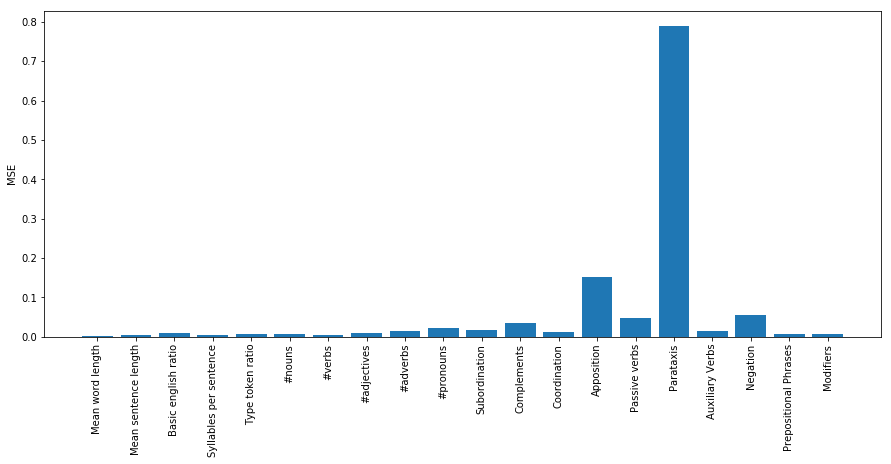

In [101]:
act = test_df.iloc[:4000][feature_columns].values
mse = [mean_squared_error(pred_reg[:,ind],act[:,ind]) for ind,feature in enumerate(feature_columns)]
fig = plt.figure(1, figsize=(15, 6))
plt.bar(feature_columns,mse)
plt.ylabel("MSE")
plt.xticks(feature_columns, rotation='vertical')
plt.show()

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


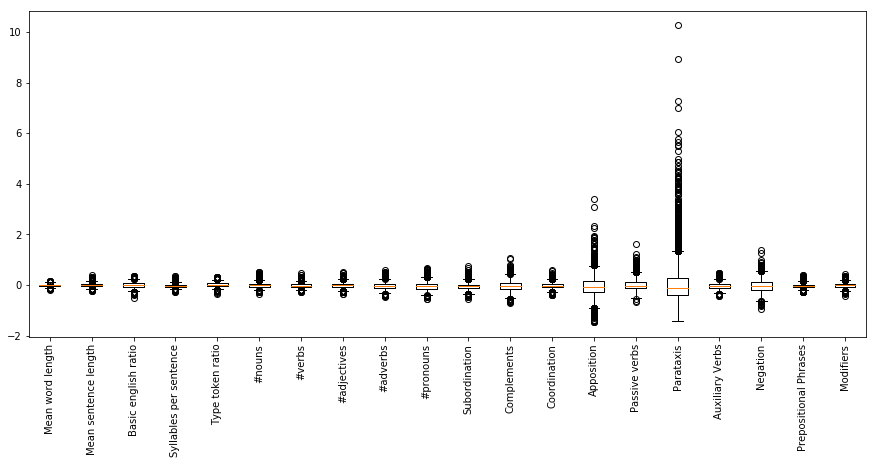

In [102]:
#Exclude 1,2,9,10 , because there are to few samples
data = [diff[:,ind] for ind,feature in enumerate(feature_columns)]

# Create a figure instance
fig = plt.figure(1, figsize=(15, 6))

# Create an axes instance
ax = fig.add_subplot(111)

ax.boxplot(data)
ax.set_xticklabels(feature_columns, rotation='vertical')
fig.show()